In [1]:
import nuctools as nuc
import numpy as np
#import metropolis as mh
import pandas as pd
from matplotlib.pyplot import *
import scipy.optimize as sp
import mpl_toolkits.axisartist as aa
from scipy.optimize import curve_fit
#style.use('C:/PyFiles/nuctools/candidacy.mplstyle')
# style.use('/Users/2mx/nuctools/nuctools/candidacy.mplstyle')
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib notebook

A,B =  582.7768594580712 0.05149689096209191
[[1.14395753e+03 1.42659922e-01]
 [1.42659922e-01 2.19135003e-05]]
dko,dks =  3.7911 4.2670 %


<IPython.core.display.Javascript object>


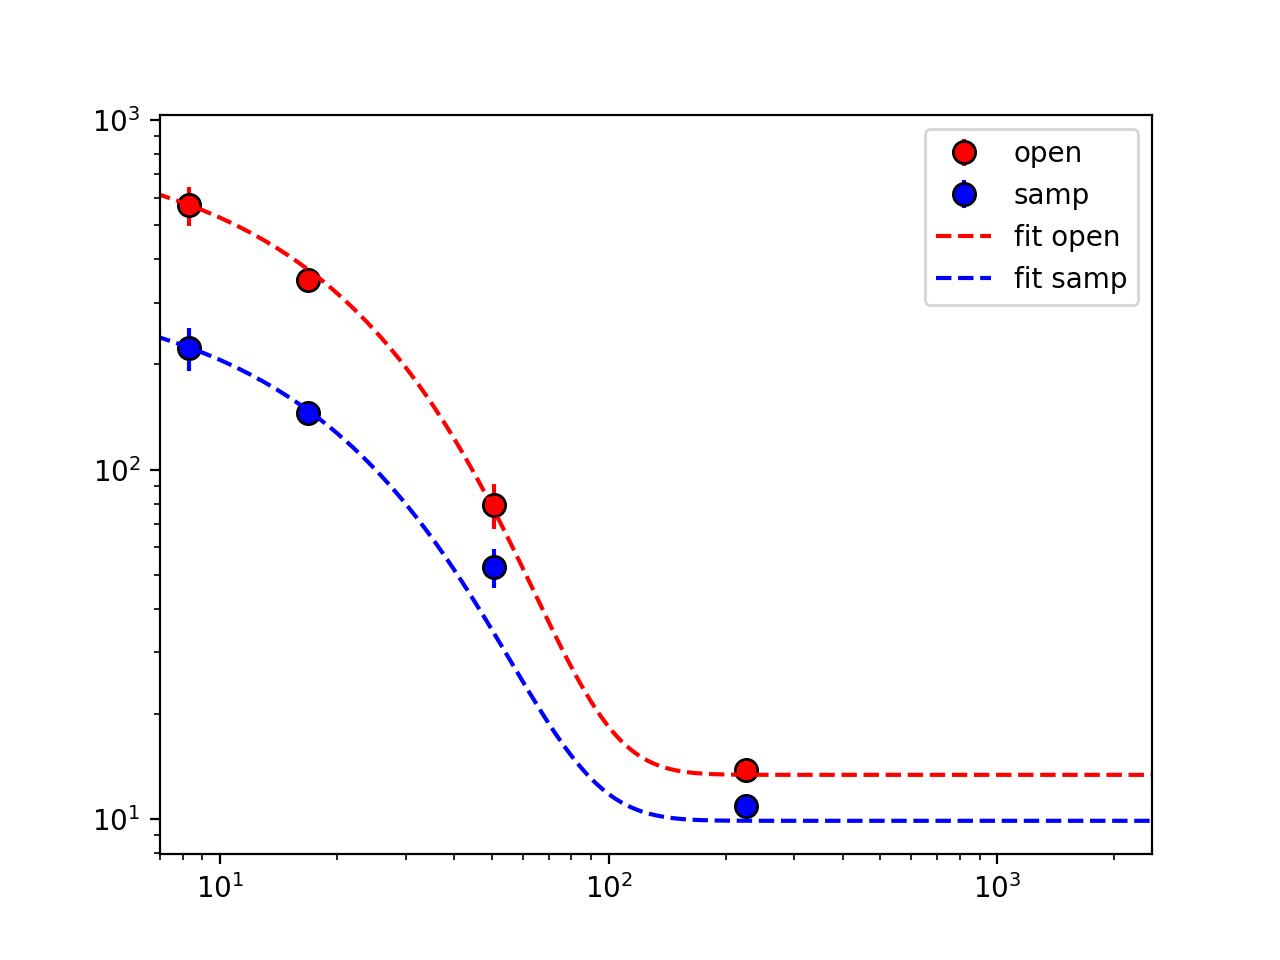

In [3]:
fake_tof = np.linspace(1,3000,3000)
# ---------------------------------
# - Constant room background ------
# ---------------------------------
b0o,db0o = 13.4,0.7
b0s,db0s = 9.9,0.1

# ---------------------------------
# from analysis-notch jupyter notebook
# ---------------------------------
notch = pd.read_csv('notch_cps.dat')
notch['avg'] = np.mean((notch.op-b0o,notch.sa-b0s),axis=0)
notch['davg'] = nuc.prop_err_mean([notch.dop,notch.dsa],axis=0) # ignores additional error due to b0

# ---------------------------------
# - Fitted function ---------------
# ---------------------------------
def exp_f(t,a,b):
    """
    .. math:: f(t) = (a)e^{-t(b)}
    """
    return a*np.exp(-t*b)

# ---------------------------------
# - scipy least squares fit -------
# ---------------------------------
# without the "absolute_sigma" option, error should come from the residuals
popt,pcov = sp.curve_fit(exp_f,notch.tof,notch.avg)#,absolute_sigma=list(notch.davg))
A,B = popt[0],popt[1]
fit_func = exp_f(fake_tof,A,B)
print("A,B = ",A,B)
print(pcov)


# ---------------------------------
# - Find appropriate norms --------
# ---------------------------------
ko = 1.471
ks = 0.563
dks = ks*notch.dsa[1]/notch.sa[1]
dko = ko*notch.dop[1]/notch.op[1]
print("dko,dks = ",nuc.four(dko/ko*100),nuc.four(dks/ks*100),'%')

# ---------------------------------
# - Plot up the notches -----------
# ---------------------------------
plot_bool = True
if plot_bool:
    figure()
    errorbar(notch.tof,notch.op,notch.dop,c='r',mec='k',marker='o',ls=' ',ms=8.0,label='open')
    errorbar(notch.tof,notch.sa,notch.dsa,c='b',mec='k',marker='o',ls=' ',ms=8.0,label='samp')
    errorbar(fake_tof,ko*fit_func+b0o,c='r',ls='--',label='fit open')
    errorbar(fake_tof,ks*fit_func+b0s,c='b',ls='--',label='fit samp')
    xscale('log')
    yscale('log')
    xlim(7,2500)
    legend()

## $T = \frac{\alpha_1C_s-\alpha_2k_sB-B0_s}{\alpha_3C_o-\alpha_4k_oB-B0o}$

### Now that we've found the background, create nuctools.Trans() objects 

In [4]:

# -----------------------------
# ---- experimental data ------
# -----------------------------
len_exp_data = 380031
data_index = np.arange(len_exp_data)+1
bw = 6.4e-3 # us
t0 = 3.326  # us
FP = 35.185 # m
Dav = 4       # eV
print(len_exp_data*bw)
# -----------------------------
# ---- grouping ---------------
# -----------------------------
res_per_bin = 50
E_cpts=[2.25e2,2000,5e3]
# set_factors = [32,    64,128, 8,16, 32,64, 256,1024,8192,16384]
# set_c_pts = [10.66,16,17.8,60,245,500,1000,1400,1650,2000]
comp_pts = [17.5,214,1000,1550,2000]
gfactor = [128,4,16,128,4096,8192]
nuc.print_chann(comp_pts,gfactor,bw*1e3,t0,FP)
# -----------------------------------------------------------
# --- backgro. ----------------------------------------------
# -----------------------------------------------------------
tabkg = [A*ks,B,0,0,b0s]
opbkg = [A*ko,B,0,0,b0o]

# -----------------------------------------------------------
# --- calculate the rates and transmission ------------------
# -----------------------------------------------------------
# trans1 = nuc.Trans(datafolder+'ta_grp_s5.dat',datafolder+'ta_Mon_s5.dat',
#                    datafolder+'ta_grp_s1.dat',datafolder+'ta_Mon_s1.dat',
#                    bkgfunction='double_exp',o_bkgcoeff=opbkg,
#                    s_bkgcoeff=tabkg,FP=FP,
#                    mon_index=0,samp_bkg_err=0.1,open_bkg_err=0.1,optstat_group=True,
#                    D=Dav,res_per_bin=res_per_bin,E_cpts=E_cpts,verbosity=False,binedge=True)
trans1 = nuc.Trans('ta_grp_s5.dat','ta_Mon_s5.dat',
                   'ta_grp_s1.dat','ta_Mon_s1.dat',
                   bkgfunction='double_exp',o_bkgcoeff=opbkg,
                   s_bkgcoeff=tabkg,factor=gfactor,c_pts=comp_pts,FP=35.185,
                   mon_index=0,samp_bkg_err=0.1,open_bkg_err=0.1)
print("\nDone.")

2432.1984
--- Paste into SAMMY res. function ---
CHANN 0    1.62 52428.8 0.8
CHANN 0    2.71 26214.4 0.8
CHANN 0    6.51 819.2 0.8
CHANN 0  145.80 102.4 0.8
CHANN 0  32211.30 25.6 0.8
--------------------------------------

Done.


<IPython.core.display.Javascript object>


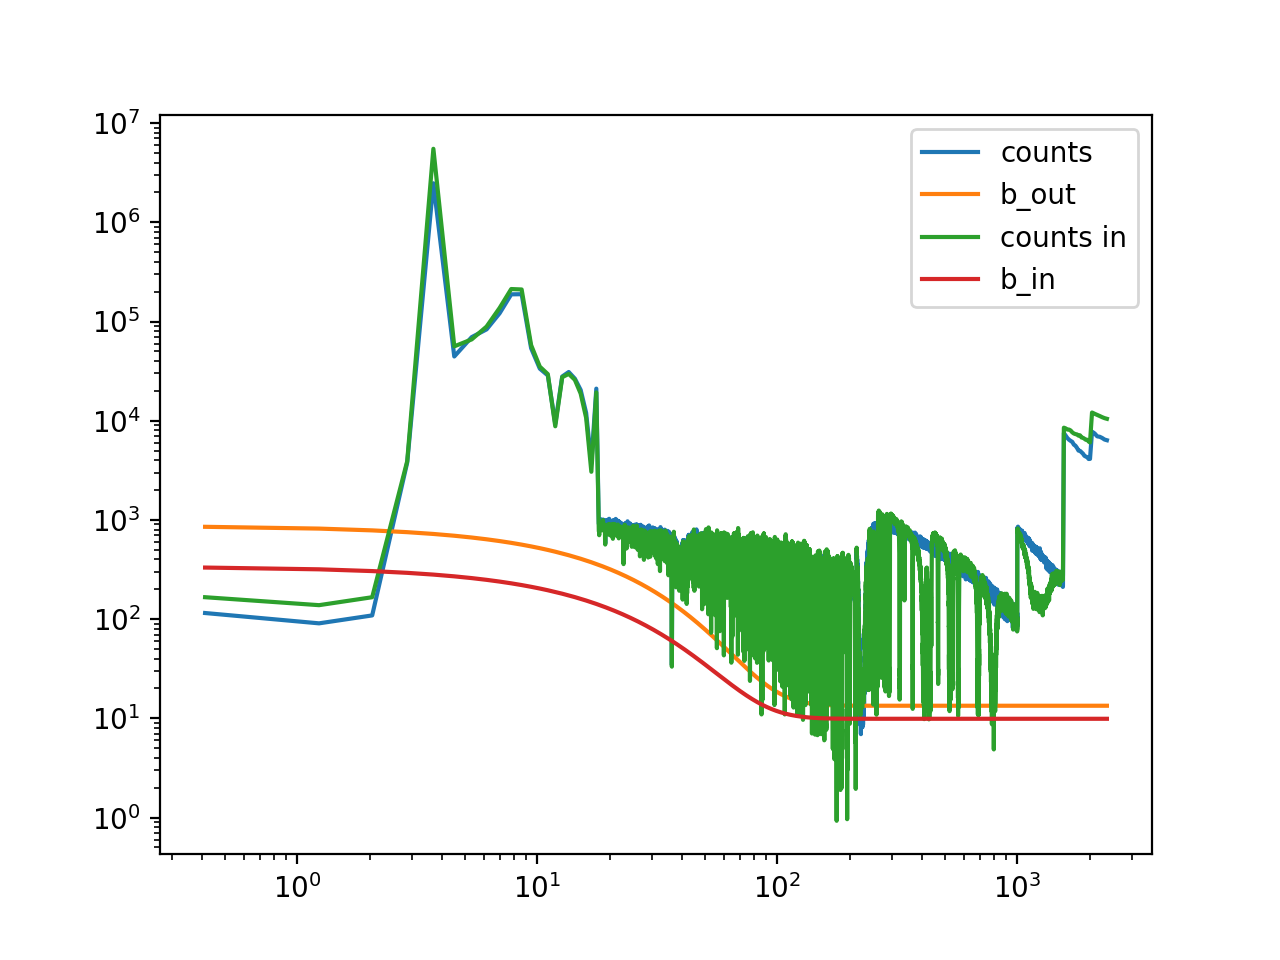

In [5]:
figure()
# plot(trans1.open_data.tof,trans1.open_data.cps,label='cps')
plot(trans1.open_data.tof,trans1.open_data.counts,label='counts')
# plot(trans1.open_data.tof,(trans1.open_data.dcps/trans1.open_data.cps)*100)
plot(trans1.open_data.tof,trans1.open_data.bkg, label='b_out')
# plot(trans1.sample_data.tof,(trans1.sample_data.dcps/trans1.sample_data.cps)*100)
plot(trans1.sample_data.tof,trans1.sample_data.counts,label='counts in')
plot(trans1.sample_data.tof,trans1.sample_data.bkg, label='b_in')
xscale('log')
yscale('log')
legend()

In [6]:
trans1.open_data[['tof','bin_width','counts','dcounts']]#.to_csv("/Users/2mx/Desktop/rpi-open-ta181.csv",index=False)

,tof,bin_width,counts,dcounts
0,0.4128,0.8192,1.152758e+02,10.736657
1,1.2320,0.8192,9.071601e+01,9.524495
2,2.0512,0.8192,1.090404e+02,10.442239
3,2.8704,0.8192,3.794709e+03,61.601208
4,3.6896,0.8192,2.474461e+06,1573.041876
...,...,...,...,...
16045,2153.4496,52.4288,6.957880e+03,83.413906
16046,2205.8784,52.4288,6.889147e+03,83.000888
16047,2258.3072,52.4288,6.699209e+03,81.848693
16048,2310.7360,52.4288,6.460441e+03,80.376870


### Now deal with the actual error, and generate the full covariance matrix and correlation matrix
- Note that the Trans class calculates error, but it's only statistical unc. and an estimate for the background

In [7]:
# ---------------------------------
# - Create convenient dataframe ---
# ---------------------------------
dfor = pd.DataFrame({
    'e' : nuc.tofe(trans1.open_data.tof-t0,FP),
    'trans': trans1.trans,
    'tof': trans1.open_data.tof,
#     'tof_l':trans1.open_data.tof_low,
    'cs' : trans1.sample_data.cps,
    'dcs': trans1.sample_data.dcps,
    'bs' : trans1.sample_data.bkg,
    'dbs': trans1.samp_bkg_err,
    'co' : trans1.open_data.cps,
    'dco': trans1.open_data.dcps,
    'bo' : trans1.open_data.bkg,
    'dbo': trans1.open_bkg_err,
    'bfit': exp_f(trans1.open_data.tof,A,B)
})
df= dfor[::-1].reset_index(drop=True)
eLimits = (3,100000)
df = dfor[(dfor.e>eLimits[0])&(dfor.e<eLimits[1])].reset_index(drop=True)
#display(df)

# -----------------------------------------------------
# - Additional error on the monitors ------------------
# --> Determined in rpy_xdr.ipynb notebook ------------
# --> Using the Amperex fission chamber ---------------
# -----------------------------------------------------
dalpha1 = 0.016 # Ta
dalpha2 = 0.008 # Ta-notches
dalpha3 = 0.018 # Op
dalpha4 = 0.005 # Op-notches  

# -----------------------------------------------------
# - Define numerator and denominator of trans function
# -----------------------------------------------------
N = (df.cs-ks*df.bfit-b0s)
D = (df.co-ko*df.bfit-b0o)

# -----------------------------------------------------
# - Calculate derivative w.r.t. all variable of trans -
# -----------------------------------------------------

# statistical
ddcs = 1/D
ddco = N/D**2

# systematic
dda  = -1*(ks*D+ko*N)/(A*D**2)
ddb  = (ks*D+ko*N)*df.bfit*df.tof/D**2
ddks = -1*df.bfit/D
ddko = 1*N*df.bfit/D**2
ddb0s = -1/D
ddb0o = 1*N/D**2
ddalpha1 = df.cs/D
ddalpha2 = -ks*df.bfit/D
ddalpha3 = -df.co*N/D**2
ddalpha4 = ko*df.bfit*N/D**2

# -----------------------------------------------------
# stat. error and derivatives listed in proper order --
# -----------------------------------------------------
stat_err_list = [df.dcs,df.dco]
stat_der_list = [ddcs,ddco]

# -----------------------------------------------------
# syst. error and derivatives listed in proper order --
# -----------------------------------------------------
sys_err_list = [dks,dko,db0s,db0o,dalpha1,dalpha2,dalpha3,dalpha4] # doesn't inc. A,B b/c they come with covar mat
sys_der_list = [dda,ddb,ddks,ddko,ddb0s,ddb0o,ddalpha1,ddalpha2,ddalpha3,ddalpha4]

# -----------------------------------------------------
# - Use nuctools to perform matrix algebra ------------
# -----------------------------------------------------
stat = nuc.stat_cov(stat_err_list,stat_der_list)
syst = nuc.sys_cov(sys_err_list,sys_der_list,cov_mat=pcov) # <-- Note I'm including bkg. cov. matrix here  ,der,cx

# -----------------------------------------------------
# - Add the systematic and statistical variance and cov
# -----------------------------------------------------
cy = stat+syst


# -------------------------------------------------------
# if pcov is not None:
#     lcm = len(pcov)
#     N = lcm + len(sys_err_list)
#     cx = np.zeros((N,N))
#     # plug in matrix at the leading rows and cols
#     cx[0:lcm,0:lcm] = pcov

# # cast as numpy arrays
# sys_err = np.array(sys_err_list)
# sys_der = np.array(sys_der_list)
# # square the error for the variance and diagonalize
# sys_err2 = np.diag(np.power(sys_err_list,2))
# # determine the final input covariance matrix
# if pcov is None:
#     cx = sys_err2
# else:
#     cx[lcm:,lcm:] = sys_err2
# # sandwich rule, matrix algebra to get outgoing covariance
# # (@ symbol is matrix dot product)
# cy = sys_der.T@cx@sys_der



In [8]:

# figure()
# plot(df.tof,np.sqrt(np.diag(stat)))
# xscale('log'); yscale('log')
# trans1.sample_data.tof


In [9]:
# figure()
# plot(df.tof,np.sqrt(np.diag(syst)))
# xscale('log'); yscale('log')
# # trans1.sample_data.tof
# # syst

# cx
# sys_err_list
# pcov, A, B
# np.power(sys_err_list,2)

<IPython.core.display.Javascript object>


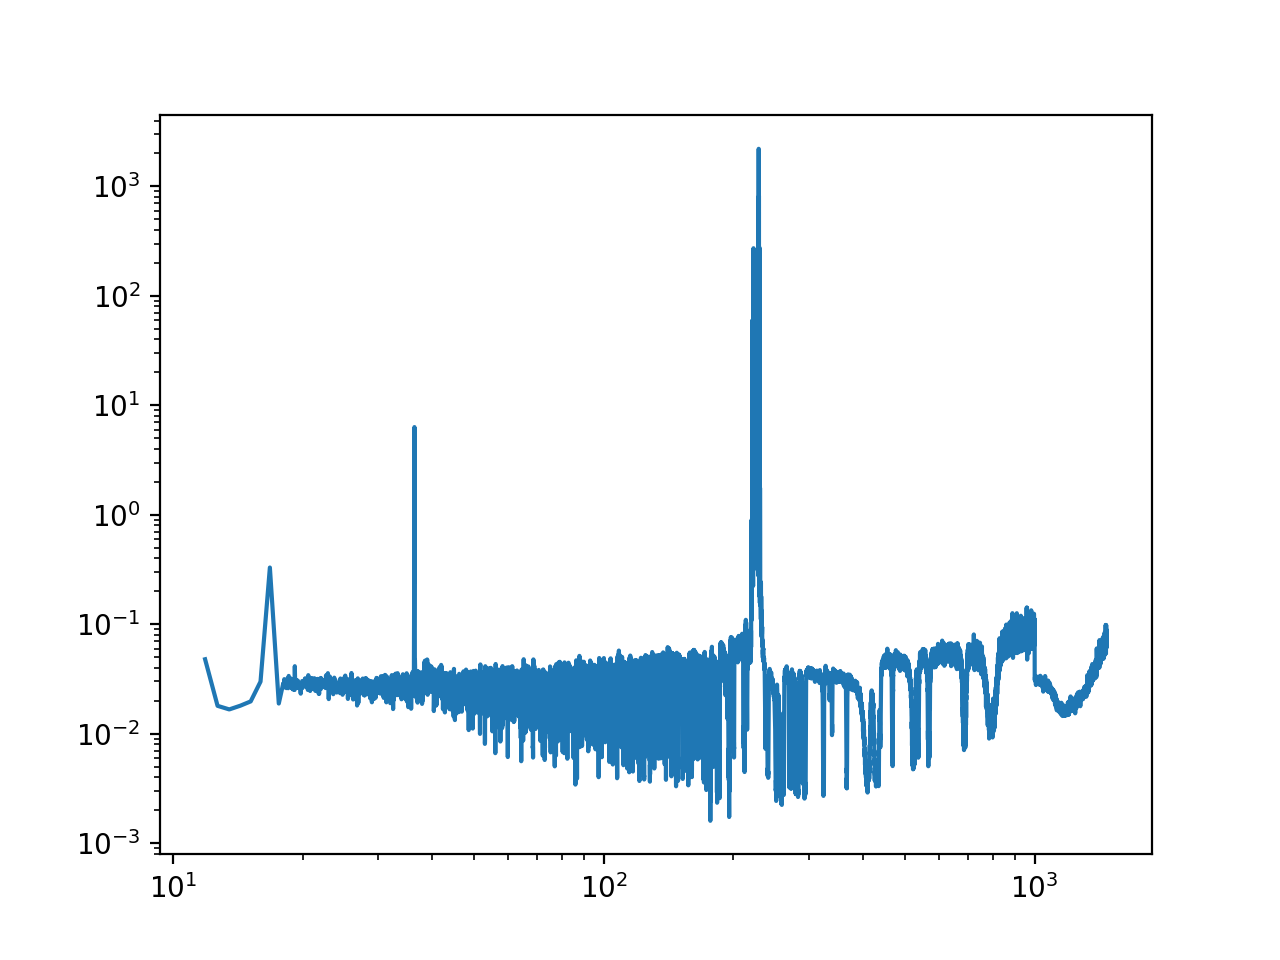

In [10]:


figure()
plot(df.tof,np.sqrt(np.diag(cy)))
xscale('log'); yscale('log')



<IPython.core.display.Javascript object>


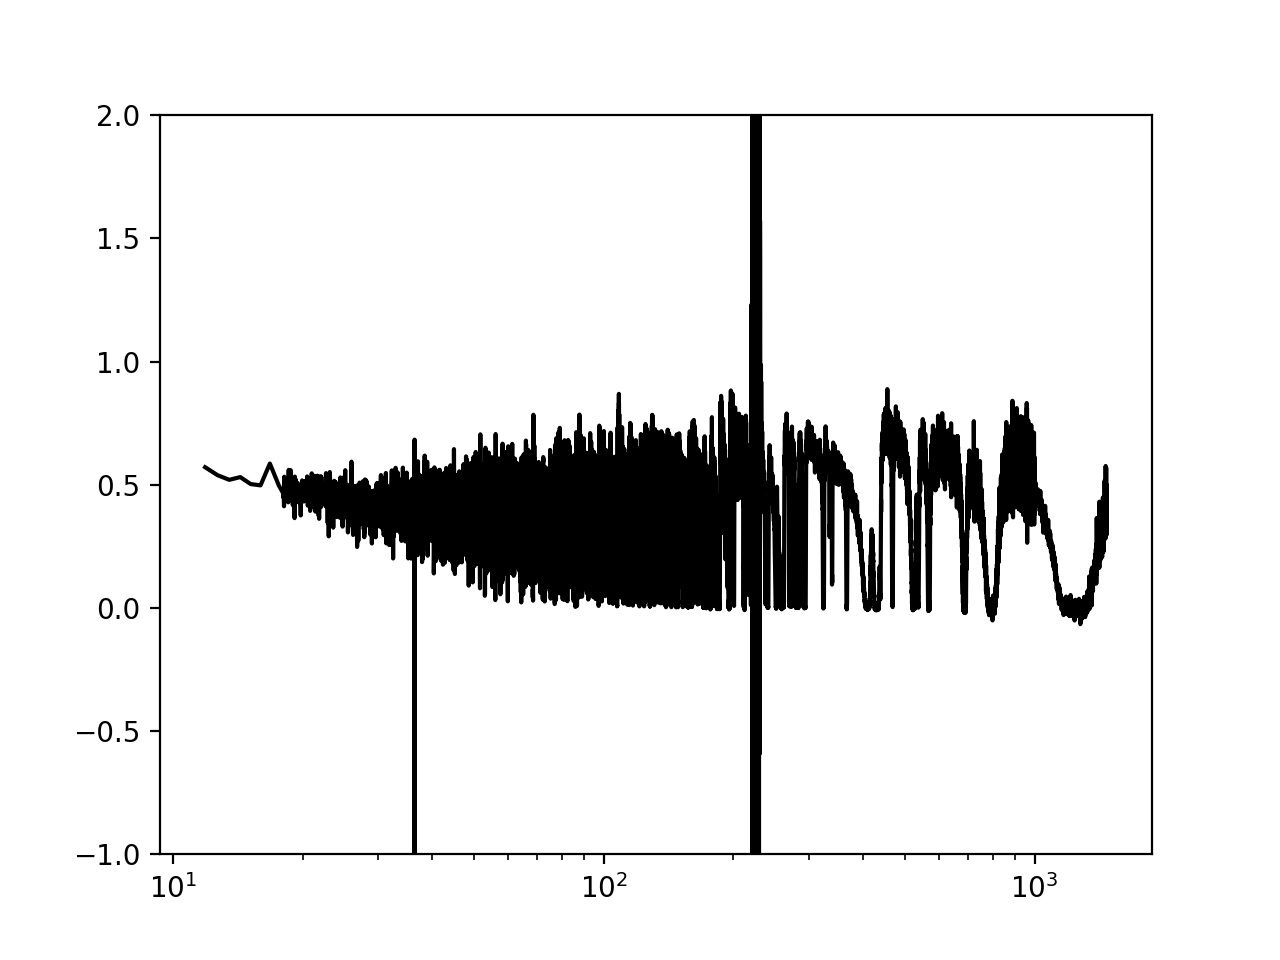

In [11]:
figure()
plot(df.tof,df.trans, ms=1, c='k')
ylim([-1,2])
#plt.xlim([1e2,1e3])
xscale('log'); 

In [12]:

# -----------------------------------------------------
# - Create corresponding correlation matrix to plot ---
# -----------------------------------------------------
#corr = nuc.cov_to_corr(cy) # <-- select region I care about

# -----------------------------------------------------
# - Put the covariance components to compact file -----
# -----------------------------------------------------
filename = '/Users/2mx/data/exfor/thick-Ta-deriv_file.dat'
sys_err_str_list = ['dks','dko','db0s','db0o','dalpha1','dalpha2','dalpha3','dalpha4']
sys_cov_str_list = ['da','db']
ptwise_str_list = ['E','t','dt','dcs','dco','dda','ddb','ddks','ddko','ddb0s','ddb0o','ddalpha1',
               'ddalpha2','ddalpha3','ddalpha4','ddcs','ddco']
sys_cov = pcov

# write the errors and derivatives to a file  
# nuc.write_covar_file(filename,df.e,df.trans,np.sqrt(np.diag(cy)),
#                      sys_err_list,stat_err_list,sys_der_list,stat_der_list,
#                      sys_err_str_list,ptwise_str_list,sys_cov=pcov,sys_cov_str_list=sys_cov_str_list)
# e2,t2,dt2,cy2 = nuc.read_covar_file(filename,2,10,2,corr_sys_input=2)
# print("Max difference after reading from file = ",np.max(cy-cy2))

print(pcov)
#df[['tof','co','dco']].to_csv("/Users/2mx/Desktop/ta181opencountrate.dat",index=False)

[[1.14395753e+03 1.42659922e-01]
 [1.42659922e-01 2.19135003e-05]]


<IPython.core.display.Javascript object>


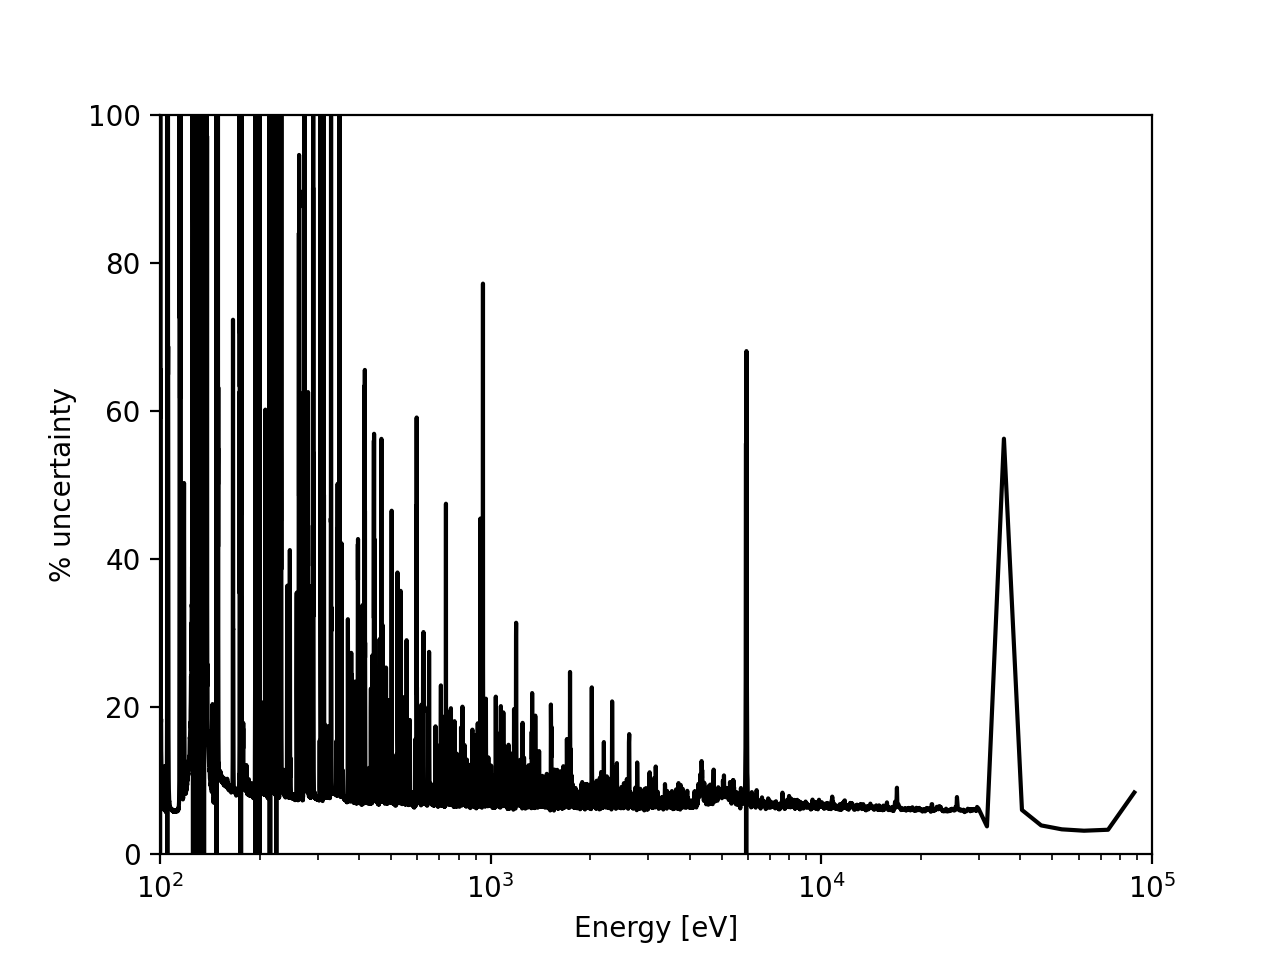

Text(0, 0.5, '% uncertainty')

In [13]:
figure(23)

plot(df.e,np.sqrt(np.diag(cy))/df.trans*100,c='k')
xscale('log')
#yscale('log')
xlim((100,100000))
ylim(0,100)
xlabel('Energy [eV]')
ylabel('% uncertainty')

### Now that we've got a correlation matrix, let's plot to see the errors and correlation

## And a final plot of grouped transmission with full errors VS simulated MCNP transmission

MCNP transmission

### $ T = \frac{\frac{C_{s,i}}{bw}}{\frac{C_{O,i}}{bw}} = \frac{C_{s,i}}{C_{O,i}}$

### $ \Delta T = \sqrt{\left(\frac{\Delta C_{s,i}}{C_{O,i}}\right)^2 + \left(\frac{\Delta C_{o,i}C_{s,i}}{C_{O,i}^2}\right)^2} = \sqrt{\left(\frac{\Delta C_{s,i}}{O}\right)^2 + \left(\frac{\Delta C_{o,i}C_{s,i}}{O^2}\right)^2}$

## Take the ratio for MCNP transmission

<IPython.core.display.Javascript object>


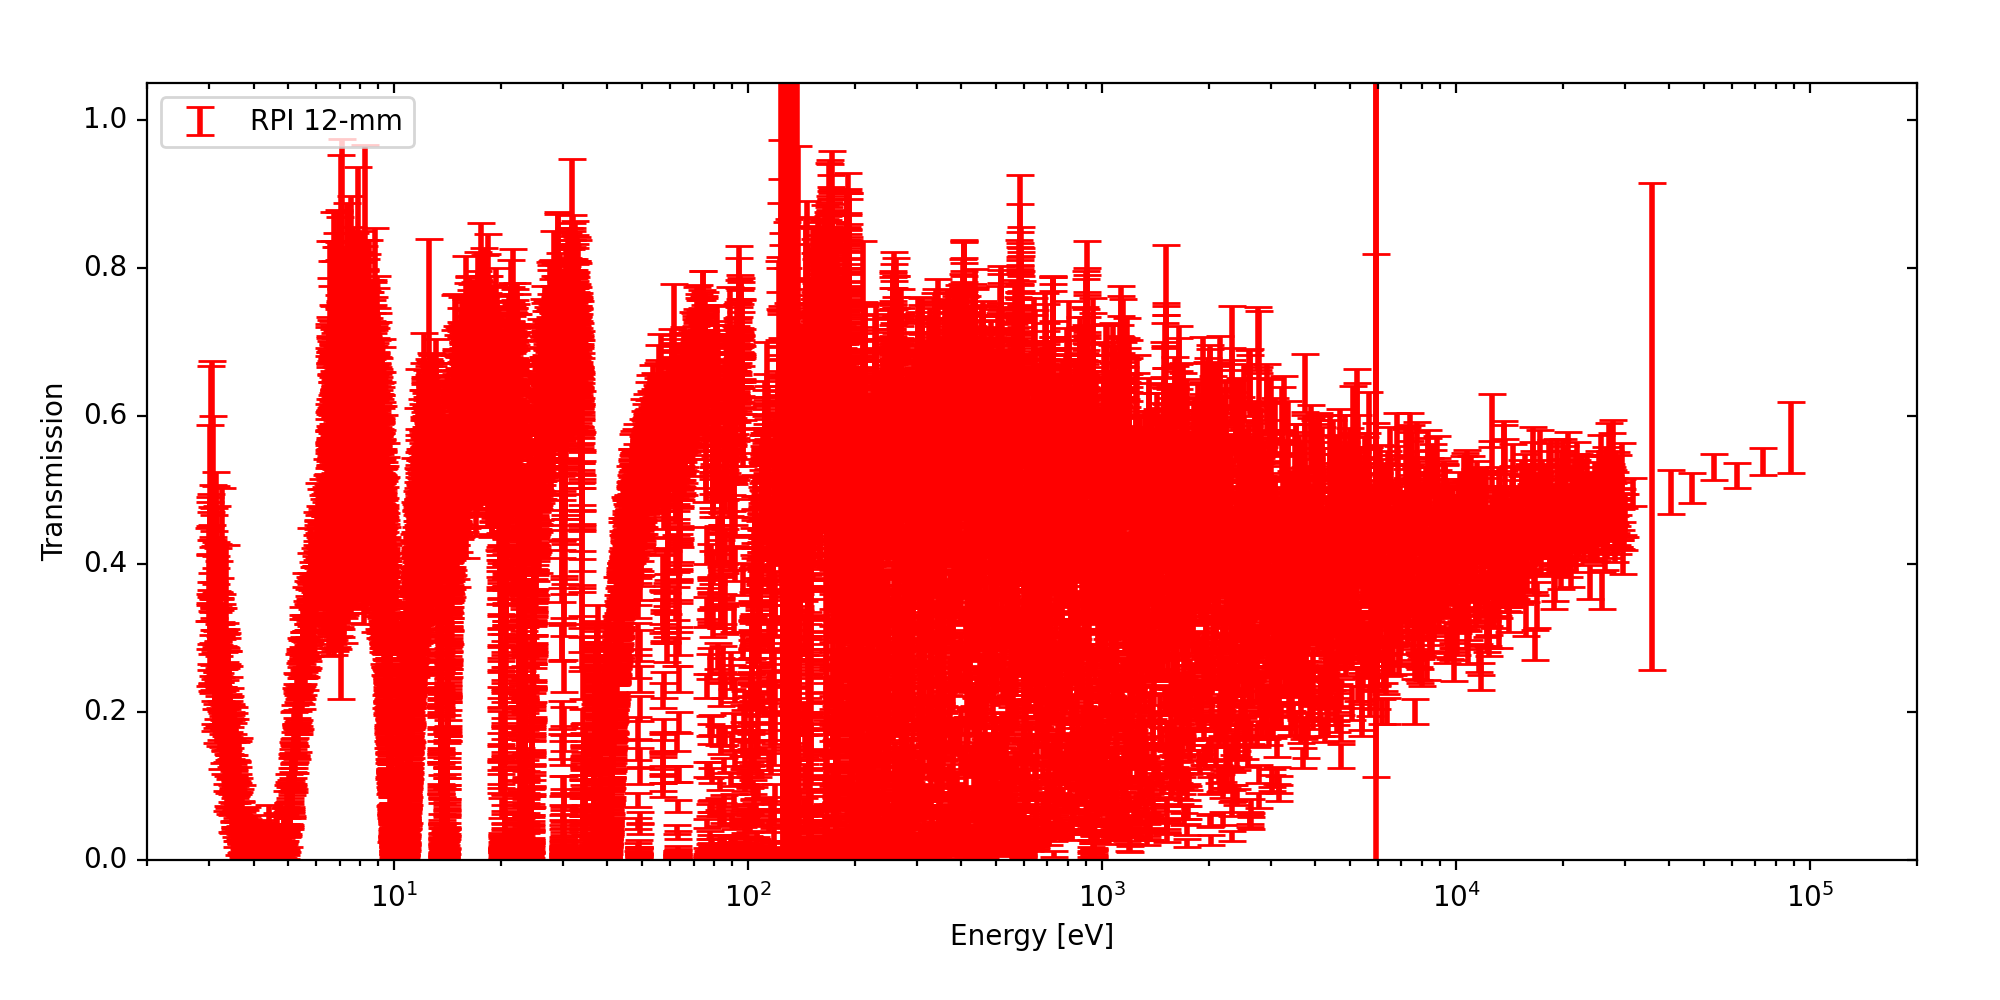

In [14]:
f = figure(28,figsize=(10,5))
ax1 = aa.Subplot(f,111)
f.add_subplot(ax1)
nuc.set_ticks_1axes(ax1)

df['dtrans'] = np.sqrt(np.diag(cy))
ax1.errorbar(df.e,df.trans,df.dtrans,c='r',ls='-',lw=.0,capsize=5.0,elinewidth=2.0,label='RPI 12-mm')

ax1.legend(loc=2,ncol=2)
ax1.set_xscale('log')
#ax1.set_xlim(145,2.5e2)
ax1.set_xlim(2,200e3)
ax1.set_ylim(0.0,1.05)
#ax1.set_yticks([0.3,0.4,0.5,0.6,0.65,0.85])
ax1.set_xlabel('Energy [eV]')
ax1.set_ylabel('Transmission')
f.tight_layout(pad=3.0)

#savefig('C:/Users/Jesse/Dropbox/figures/savefigure_',dpi=800)

In [15]:
df


,e,trans,tof,cs,dcs,bs,dbs,co,dco,bo,dbo,bfit,dtrans
0,88416.045425,0.571458,11.8816,580.950003,6.195396,187.842997,0.1,1166.229542,12.078151,478.327440,0.1,3.160622e+02,0.047875
1,73637.283950,0.538982,12.7008,1814.838405,10.950114,180.492386,0.1,3491.405805,20.898187,459.121847,0.1,3.030060e+02,0.017972
2,62276.564917,0.520194,13.5200,1959.652939,11.378611,173.445420,0.1,3874.441705,22.014712,440.709615,0.1,2.904892e+02,0.016668
3,53355.681453,0.531282,14.3392,1707.443607,10.621182,166.689556,0.1,3323.128704,20.388347,423.057969,0.1,2.784894e+02,0.018018
4,46222.889688,0.502918,15.1584,1241.464506,9.056634,160.212768,0.1,2556.093274,17.881205,406.135492,0.1,2.669854e+02,0.019725
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15910,3.015622,0.417764,1468.1888,18.485957,1.105149,9.900000,0.1,33.952195,2.060831,13.400000,0.1,8.506101e-31,0.072422
15911,3.012251,0.349083,1469.0080,17.332079,1.070102,9.900000,0.1,34.690271,2.083110,13.400000,0.1,8.154724e-31,0.064264
15912,3.008887,0.297559,1469.8272,15.890513,1.024634,9.900000,0.1,33.532182,2.048044,13.400000,0.1,7.817863e-31,0.062336
15913,3.005528,0.500051,1470.6464,18.931344,1.118383,9.900000,0.1,31.460858,1.983781,13.400000,0.1,7.494916e-31,0.088329


In [16]:

# --- Form the full systematic covariance matrix for input to IDC-creator function
K = len(sys_cov)+len(sys_err_list)
syst = np.zeros((K,K))
syst[0:len(sys_cov),0:len(sys_cov)] = sys_cov
for i in range(len(sys_err_list)):
    index = i+len(sys_cov)
    syst[index,index] = sys_err_list[i]**2

# nuc.write_sammy_idc_file('/Users/2mx/Desktop/','ta-181-12mm',df.e,df.trans,np.sqrt(np.diag(cy)),stat,
#                      syst,sys_der_list)

#nuc.fmt_twenty([df.e,df.trans,np.sqrt(np.diag(cy))],'/Users/2mx/Desktop/ta-181-12mm.twenty')

In [17]:
nuc.tofe(50000/100,35.18)

25.8766051918735

In [18]:
# print(len(trans1.sample_data))
# for i in range(len(df.tof)):
#     print("{:1.4e} {:1.6e}".format(nuc.tofe(df.tof[i]-t0,FP),
#           nuc.tofe(df.tof[i]-1/2*nuc.prop_err_mean(np.repeat(bw,trans1.sample_data.bin_width[i]/bw))-t0,FP) -
#           nuc.tofe(df.tof[i]+1/2*nuc.prop_err_mean(np.repeat(bw,trans1.sample_data.bin_width[i]/bw))-t0,FP)))
# display(df[47:77])

In [19]:
nuc.tofe(56.8815-1/2*bw,FP)-nuc.tofe(56.8815+1/2*bw,FP)

0.4500599231498654

In [20]:
a = np.array([[2,3],[2.1,4],[1.9,3]])
b = np.cov(a,rowvar=False)
print(b)
c = np.corrcoef(a,rowvar=False)
print("\n",c)
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation
print('\n',correlation_from_covariance(b))

[[0.01       0.05      ]
 [0.05       0.33333333]]

 [[1.        0.8660254]
 [0.8660254 1.       ]]

 [[1.        0.8660254]
 [0.8660254 1.       ]]


In [21]:
import numpy as np
file = '/Users/2mx/data/exfor/Ta-181-12mm-exfor-submission.dat'
err = np.genfromtxt(file,skip_header=3,max_rows=1,delimiter=",") # data-reduction uncertainty
corr_lt = np.genfromtxt(file,skip_header=6,max_rows=10,delimiter=",",filling_values=0.0) # lower-triang
corr = corr_lt + corr_lt.T - np.diag(np.diag(corr_lt))     # correlation matrix: data-reduction
cy = corr * np.outer(err,err)                              # covariance matrix: data-reduction
edep = np.genfromtxt(file,skip_header=18,delimiter=",")    # energy-dependent quantities
fy = edep[:,7:]                                            # sensitivities for data-redux parameters   
c_sys = fy@cy@fy.T                                         # covariance of T for systematic
c_stat = np.diag(edep[:,6]**2)                             # covariance of T for statistical
C = c_sys + c_stat                                         # total covariance
print(np.sqrt(np.diag(C)))

OSError: /Users/2mx/data/exfor/Ta-181-12mm-exfor-submission.dat not found.

In [ ]:
#df[(df.e>200)&(df.e<200e3)]
df['dstat'] = np.sqrt(np.diag(stat))
for i in df.index[(df.e>200)&(df.e<200e3)]:
    print("{:9.6e}, {:9.6e},{:9.6e}".format(nuc.tofe(df.tof_l[i-1]-t0,FP),nuc.tofe(df.tof_l[i]-t0,FP),df.dstat[i]))

In [ ]:
df[['e','trans','dtrans','tof','cs','dcs','co','dco','bs','bo']].to_csv("/Users/2mx/Desktop/full-ta-181-12mm.dat",index=False)

In [ ]:
import time
start = time.time()

a = np.random.rand(12000,10000)
b = np.random.rand(10000,10000)
c = a@b@a.T

end = time.time()
print("{:.5f} secs".format(end-start))